# Object Detection Demo
Welcome to the object detection inference walkthrough!  This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image. Make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/object_detection/g3doc/installation.md) before you start.

# Imports

In [71]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
from __future__ import print_function

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
print("done")

done


## Env setup

In [2]:
# This is needed to display the images.
%matplotlib inline

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
print(sys.version)

3.5.1 (v3.5.1:37a07cee5969, Dec  5 2015, 21:12:44) 
[GCC 4.2.1 (Apple Inc. build 5666) (dot 3)]


## Object detection imports
Here are the imports from the object detection module.

In [74]:
from utils import label_map_util

from utils import visualization_utils as vis_util

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_CKPT` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [75]:
# What model to download.
# What model to download.
MODEL_NAME = 'car_detection_inference_graph 2'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('training', 'object-detection.pbtxt')

NUM_CLASSES = 5
print("done")

done


## Download Model

In [5]:
#opener = urllib.request.URLopener()
#opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
#tar_file = tarfile.open(MODEL_FILE)
#for file in tar_file.getmembers():
#  file_name = os.path.basename(file.name)
#  if 'frozen_inference_graph.pb' in file_name:
#    tar_file.extract(file, os.getcwd())
    
#print("done")

## Load a (frozen) Tensorflow model into memory.

In [76]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')
print("done")

done


## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [77]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

## Helper code

In [78]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detection

In [79]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = 'test_images'
#TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 3) ]
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 6) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)
print("done")

done


In [80]:
def getLabel(input_value ):
    if input_value == 1:
        return "Car"
    elif input_value ==2:
        return "Van"
    elif input_value ==3:
        return "pickup-truck"
    elif input_value ==4:
        return 'truck'
    elif input_value ==5:
        return 'bus'

Scriptet är nu tweakat för att skriva ut svaren till en CSV fil. Har satt ett threshold på
0.5 som går att ändra så att vi kan ha ett flytande threshold. Detta syns dock inte på bilderna
plottas men tror att det är föra att visualiserings verktyget har en inbyggd threshold. 
Normalt trycker den ut de 100 boxes(Tror det är inställt att ta de 100 med störrst sannolikhet att vara något)

Det behövs mer testning för att se så att scriptet stammer! Det kan också snyggas till! 

The image is : test_images/image2.jpg
1.0
0.637464
The boxes is : [ 0.40618506  0.46404681  0.50513542  0.51730025]
The image is : test_images/image3.jpg
1.0
0.713191
The boxes is : [ 0.5084902   0.57502371  0.56882071  0.6135729 ]
The image is : test_images/image5.jpg
1.0
0.755356
The boxes is : [ 0.58051342  0.4183391   0.73004931  0.51381987]
The image is : test_images/image5.jpg
1.0
0.566273
The boxes is : [ 0.57914114  0.34317476  0.65926325  0.38881421]


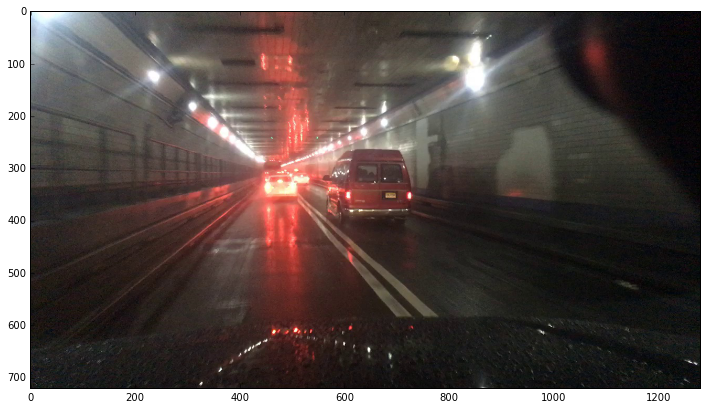

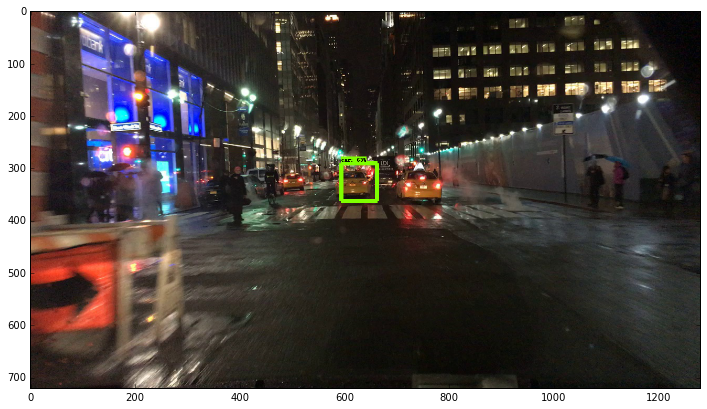

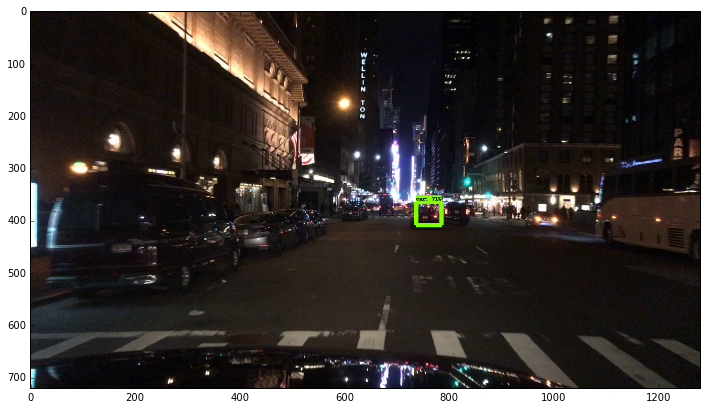

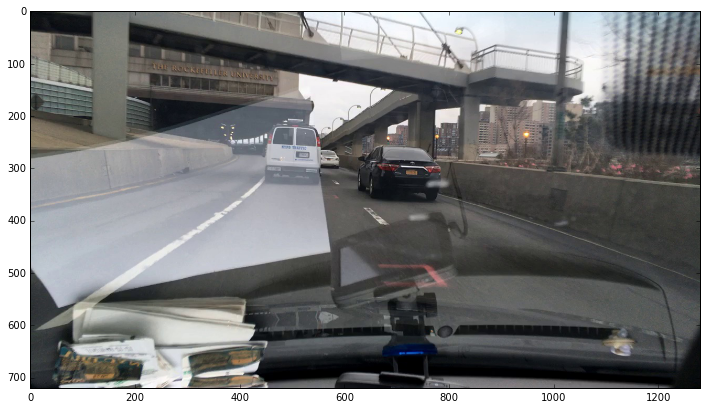

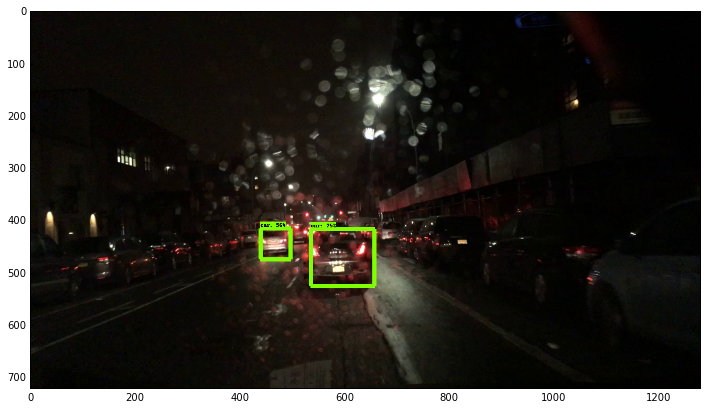

In [81]:
f = open('test_images/predictions.csv','w')
f.write("image_filename,x0,y0,x1,y1,label,confidence\n") #Give your csv text here.
f.close()

with detection_graph.as_default():
  with tf.Session(graph=detection_graph) as sess:
    # Definite input and output Tensors for detection_graph
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
    # Each box represents a part of the image where a particular object was detected.
    detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
    # Each score represent how level of confidence for each of the objects.
    # Score is shown on the result image, together with the class label.
    detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
    detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')
    for image_path in TEST_IMAGE_PATHS:
      image = Image.open(image_path)
      # the array based representation of the image will be used later in order to prepare the
      # result image with boxes and labels on it.
      image_np = load_image_into_numpy_array(image)
      # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
      image_np_expanded = np.expand_dims(image_np, axis=0)
      # Actual detection.
      (boxes, scores, classes, num) = sess.run(
          [detection_boxes, detection_scores, detection_classes, num_detections],
          feed_dict={image_tensor: image_np_expanded})
      scores=np.squeeze(scores) 
      boxes=np.squeeze(boxes)
     #
      classes=np.squeeze(classes) 
      for index,score in enumerate(scores):
          if score>0.5:
            print("The image is : {}".format(image_path))
            image_name=image_path.split('/', 1)[-1]
            f = open('test_images/predictions.csv','a') 
            f.write("{},".format(image_name))
            for number,cordinates in enumerate(boxes[index]):
                if (number ==0 or number ==2):
                    f.write("{},".format(cordinates*720))
                else:
                    f.write("{},".format(cordinates*720))
            print(classes[0])    
            f.write("{}".format(getLabel(classes[0])))
            print(score)
            print("The boxes is : {}".format(boxes[index]))
      # Visualization of the results of a detection.
      # Visualization of the results of a detection.
            f.write(",{}".format(score))
            f.write("\n")
            f.close()
      vis_util.visualize_boxes_and_labels_on_image_array(
          image_np,
          np.squeeze(boxes),
          np.squeeze(classes).astype(np.int32),
          np.squeeze(scores),
          category_index,
          use_normalized_coordinates=True,
          line_thickness=8)
      plt.figure(figsize=IMAGE_SIZE)
      plt.imshow(image_np)

Har tweakat scriptet för evaluation nedanför! Det är nu så att vi kan köra med våra egena CSV filer i teorin. 

Det behöver testas med våra filer! Har råkat ta bort bilderna och måste ladda ner dem igen för att få med labels och råbilder så jag kan kolla. 

In [55]:
# --------------------------------------------------------------------------------------------------
#
#   ITAY : Need to change header
#   Copyright (c) 2016-2017. Nexar Inc. - All Rights Reserved. Proprietary and confidential.
#
#   Unauthorized copying of this file, via any medium is strictly prohibited.
#
# --------------------------------------------------------------------------------------------------


from __future__ import print_function

import os
import csv
import argparse

DEBUG = False

class Box:
    def __init__(self,csv_row = None, img_name=None):
        self.x0 = csv_row[1]
        self.y0 = csv_row[2]
        self.x1 = csv_row[3]
        self.y1 = csv_row[4]
        self.label = csv_row[5]
        self.confidence = csv_row[6]
        self.img_name = img_name
        self.is_matched = False

    def __str__(self):
        out_str = '[{},{}] x [{},{}] : {} (confidence={})'.format(self.x0,self.x1,self.y0,self.y1,self.label,self.confidence)
        return out_str

    def __lt__(self, other):
         return self.confidence < other.confidence

class EvalDetector:
    def __init__(self, conf, precision, recall):
        self._conf = conf
        self._precision = precision
        self._recall = recall

    def AP(self):
        """
        Compute average precision for submission to Nexar's second challenge
        :return: Average precision (float)
        """
        prev_recall_value = 0.0
        ap = 0.0
        for conf, precision, recall in zip(self._conf,self._precision,self._recall):
            delta = recall - prev_recall_value
            ap += precision * delta
            prev_recall_value = recall
        return ap



def read_boxes_from_csv(csv_file):
    boxes = {}
    img = []
    with open(csv_file, 'rt') as f:
        reader = csv.reader(f)
        for i,row in enumerate(reader):
            if i > 0:
                img_name = row[0]
                img.append(img_name)
                row[1:5] = [float(e) for e in row[1:5]]
                row[6] = float(row[6])
                if img_name in boxes:
                    boxes[img_name].append(Box(csv_row=row,img_name=img_name))
                else:
                    boxes[img_name] = [Box(csv_row=row,img_name=img_name)]

    return boxes


def iou(box1, box2):
    lr = (min(box1.x1,box2.x1) - max(box1.x0, box2.x0)) + 1
    if lr > 0:
        tb = (min(box1.y1,box2.y1) - max(box1.y0, box2.y0)) + 1

        if tb > 0:
            intersection = tb * lr
            w1 = box1.x1 - box1.x0 + 1
            h1 = box1.y1 - box1.y0 + 1
            w2 = box2.x1 - box2.x0 + 1
            h2 = box2.y1 - box2.y0 + 1
            union = (w1*h1 + w2*h2) - intersection
            return float(intersection) / float(union)

    return 0.0


def find_best_iou_box(detector_box, ground_truth_boxes):
    best_iou = -1
    best_i = -1
    for i, gt_box in enumerate(ground_truth_boxes):
        if not gt_box.is_matched:
            computed_iou = iou(detector_box,gt_box)
            if  computed_iou > best_iou:
                best_iou = computed_iou
                best_i = i

    return best_i, best_iou

def eval_detector_csv(gt_csv_file, detector_csv_file, iou_threshold):
    ground_truth_boxes_by_img = read_boxes_from_csv(gt_csv_file)
    if DEBUG:
        print ('Ground truth: cvs - {} , Number images = {}'.format(gt_csv_file,len(ground_truth_boxes_by_img)))

    detector_boxes_by_img = read_boxes_from_csv(detector_csv_file)
    if DEBUG:
        print ('Detector: cvs - {} , Number images= {}'.format(detector_csv_file,len(detector_boxes_by_img)))

    n_empty_gt_images = 0
    for img_obj in detector_boxes_by_img:
        if img_obj not in ground_truth_boxes_by_img:
            if DEBUG:
                print ('ERROR: detected image name not a ground truth image: {}'.format(img_obj))
            n_empty_gt_images += 1
            continue
    if DEBUG:
        print('Number of empty GT images: {}'.format(n_empty_gt_images))

    return eval_detector(ground_truth_boxes_by_img, detector_boxes_by_img, iou_threshold)


def eval_detector(ground_truth_boxes_by_img, detector_boxes_by_img, iou_threshold):
    n_ground_truth_boxes = 0
    for img in ground_truth_boxes_by_img:
        n_ground_truth_boxes += len(ground_truth_boxes_by_img[img])

    all_detected_boxes = []
    for d in detector_boxes_by_img.values():
        all_detected_boxes += d
    all_detected_boxes.sort(reverse=True)

    n_correct_detected_boxes = 0
    n_detected_boxes = 0
    conf = [0.0] * len(all_detected_boxes)
    precision = [0.0] * len(all_detected_boxes)
    recall = [0.0] * len(all_detected_boxes)
    for k, detector_box in enumerate(all_detected_boxes):
        n_detected_boxes += 1
        if detector_box.img_name in ground_truth_boxes_by_img:
            ground_truth_boxes = ground_truth_boxes_by_img[detector_box.img_name]
        else:
            ground_truth_boxes = []

        best_ground_truth_i, best_ground_truth_iou = find_best_iou_box(detector_box, ground_truth_boxes)
        is_match = (best_ground_truth_i >=0) and  (best_ground_truth_iou >= iou_threshold)
        if is_match:
            # detector_box matched to ground truth box
            ground_truth_boxes[best_ground_truth_i].is_matched = True
            n_correct_detected_boxes += 1

        conf[k] = detector_box.confidence
        precision[k] = float(n_correct_detected_boxes)/float(n_detected_boxes)
        recall[k] = float(n_correct_detected_boxes)/float(n_ground_truth_boxes)

    edetect = EvalDetector(conf,precision,recall)

    return edetect.AP()


def main():
    #parser = argparse.ArgumentParser()

    #parser.add_argument('-g', help='Ground truth csv file', action='store')
    #parser.add_argument('-d', help='Detector csv file', action='store')

    #args = parser.parse_args()
    
    #gt_csv =  args.g
    #dt_csv = args.d
    #gt_csv ='challenge2_evaluation_master/data/gt.csv'
    #dt_csv ='challenge2_evaluation_master/data/dt.csv'
    gt_csv = 'dt.csv'
    dt_csv = 'test_images/predictions.csv'

    if not os.path.isfile(gt_csv):
        print ('Can not find ground truth csv file: {}'.format(gt_csv))
        exit(-1)

    if not os.path.isfile(dt_csv):
        print ('Can not find ground truth csv file: {}'.format(dt_csv))
        exit(-1)

    iou_threshold = 0.75
    print ('{}'.format(eval_detector_csv(gt_csv, dt_csv, iou_threshold)))




if __name__ == "__main__":
    main()




0.0


In [ ]:
0.7131908535957336
0.6374638676643372